# Games Release data set (with PyQrack quantum associative memory)

"PyQrack" is a pure Python language standard wrapper for the (C++11) Qrack quantum computer simulator library. PyQrack exposes a "quantum neuron" called "`QrackNeuron`." (Its API reference is [here](https://pyqrack.readthedocs.io/en/latest/autoapi/pyqrack/qrack_neuron/index.html).) We'd like to model a simple data set to achieve a proof-of-concept of using `QrackNeuron`.

In [1]:
#!pip install pyqrack

First, load the data set into a `pandas` dataframe.

In [2]:
import pandas as pd

df = pd.read_csv('games-release/games-release-ALL.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df = df.drop(['game', 'link', 'release', 'total_reviews'], axis=1)

df['peak_players'] = df['peak_players'].str.replace(',', '').astype(int)
df['positive_reviews'] = df['positive_reviews'].str.replace(',', '').astype(int)
df['negative_reviews'] = df['negative_reviews'].str.replace(',', '').astype(int)
df['total_reviews'] = df['positive_reviews'] + df['negative_reviews']
df['rating'] = df['rating'].str.replace('%', '').astype(float)

df['postive_fraction'] = df['positive_reviews'] / df['total_reviews']
df['rating'] = df['rating'] / 100

df.drop(['positive_reviews', 'negative_reviews'], axis=1)

print(df.head())
print("Number of observations: ", df.shape[0])

   peak_players  positive_reviews  negative_reviews  rating  total_reviews  \
0          4529             19807               227  0.9639          20034   
1        168191             61752              1616  0.9575          63368   
2         15543             12643               213  0.9554          12856   
3          1415             11717               209  0.9539          11926   
4          6132             14152               324  0.9509          14476   

   postive_fraction  
0          0.988669  
1          0.974498  
2          0.983432  
3          0.982475  
4          0.977618  
Number of observations:  66427


Is our dependent variable Gaussian-distributed?

<AxesSubplot:>

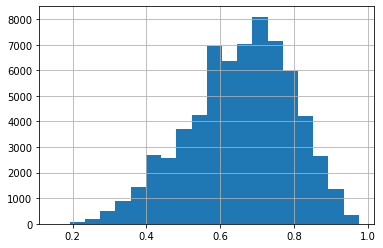

In [3]:
import math
df['rating'].hist(bins=20)

<AxesSubplot:>

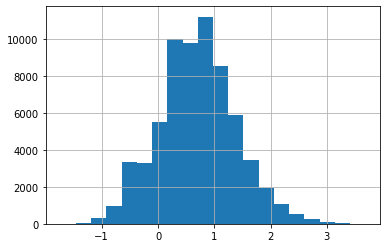

In [4]:
df['rating'].apply(lambda x: math.log(x / (1 - x))).hist(bins=20)

The logistic transformation looks best, which is fortunate, as the assumptions of linear regression are not strictly satisfied for predicting a dependent variable with ceiling and floor effects (at 0% and 100%). We're regressing against `positive_fraction`, which has the same ceiling and floor effects, so we can hypothesize that it is a direct estimator.

How about the independent variables?

<AxesSubplot:>

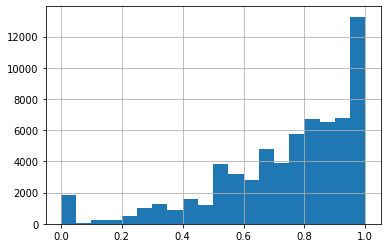

In [5]:
df['postive_fraction'].hist(bins=20)

Again, we hypothesize that `positive_fraction` is a direct estimator of `rating`. We'll see if the validation supports our hypothesis.

Separate the dependent and independent variables.

In [6]:
keys = ['peak_players', 'total_reviews', 'postive_fraction']
dep_key = 'rating'

X = df[keys]
y = df[dep_key] 

Ideally, we'd like to make an improvement on the goodness-of-fit of multiple linear regression, with PyQrack's `QrackNeuron`. At the very least, to show that `QrackNeuron` can be viable for modeling a data set, we'd like to show somehwat comparable performance to multiple linear regression.

PyQrack's `QrackNeuron` can only work with discrete, binary data. To model this or any data set, we have to reduce it to a simple, discrete, binary form.

We'll try to model the data set via "(quantum) associative memory." There are several statistical considerations, to avoid overfit.

Firstly, each possible discretized independent variable permutation input trains an independent parameter of a `QrackNeuron`. If a `QrackNeuron` has never seen a specific, exact permutation of input bits, it has no information about them at all, so its prediction defaults to "maximal superposition," (i.e. a totally random guess). Therefore, we'd like to keep our number of possible distinct inputs significantly fewer in number than our observation rows, when we discretize our indepedent variables.

Satisfying the first consideration, we secondly discretize our dependent variable to have exactly as many possible discrete values as possible distinct inputs. (We guess that this loses the least information about the dependent variable, while we still have enough observations to fully train our network.)

Thirdly, our learning rate should should just barely "saturate" the learned parameters of our (quantum) associative memory. As a learning volatility parameter ("`eta`") of `1/2` "fully trains" one parameter of a `QrackNeuron` between input qubits and output qubit, on average, this implies that we might set `eta` to `1/2` times `2` to the power of input qubits (summed across all predictors) divided by the number of observations. 

Start by splitting the data set into equal halves for training and validation.

In [7]:
train=df.sample(frac = 1/2)
test=df.drop(train.index)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

X = train[keys]
y = train[dep_key]

X_test = test[keys]
y_test = test[dep_key]

At a baseline, our first choice to model this data set might be multiple linear regression.

In [8]:
from sklearn import linear_model

regr = linear_model.LinearRegression()
regr.fit(X, y)
pd.DataFrame(zip(X.columns, regr.coef_))

,0,1
0,peak_players,1.076366e-07
1,total_reviews,6.897245e-07
2,postive_fraction,5.027714e-01


In [9]:
y_pred = regr.predict(X)
sst = 0
ssr = 0
for i in range(len(y_pred)):
    sst += y[i] * y[i]
    ssr += (y[i] - y_pred[i]) * (y[i] - y_pred[i])

print("Multiple linear regression training R^2: ", 1 - ssr / sst)

Multiple linear regression training R^2:  0.9884509895974009


In [10]:
y_pred = regr.predict(X_test)
sst = 0
ssr = 0
for i in range(len(y_pred)):
    sst += y_test[i] * y_test[i]
    ssr += (y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i])

print("Multiple linear regression validation R^2: ", 1 - ssr / sst)

Multiple linear regression validation R^2:  0.9863378114586118


To discretize the data, we split it into as many quantiles as `2` to the power of our number of input qubits.

In [11]:
import numpy as np

in_qubit_count = 4

in_key_count = len(keys)
in_bin_count = 1 << in_qubit_count
in_tot_count = in_key_count * in_qubit_count
out_qubit_count = in_key_count * in_qubit_count
out_bin_count = 1 << out_qubit_count

x_bins = []
for key in keys:
    x_bins.append(np.percentile(X[key], np.arange(0, 100, 100 / (2 * in_bin_count)))[1::2])
y_bins = np.percentile(y, np.arange(0, 100, 100 / (2 * out_bin_count))[1::2])

In [12]:
print(x_bins)

[array([1.00000000e+00, 2.00000000e+00, 2.00000000e+00, 3.00000000e+00,
       3.00000000e+00, 4.00000000e+00, 4.00000000e+00, 6.00000000e+00,
       8.00000000e+00, 1.10000000e+01, 1.80000000e+01, 3.20000000e+01,
       6.90000000e+01, 1.64000000e+02, 5.19562500e+02, 2.83509375e+03]), array([1.0000000e+00, 3.0000000e+00, 4.0000000e+00, 6.0000000e+00,
       9.0000000e+00, 1.2000000e+01, 1.7000000e+01, 2.3000000e+01,
       3.1000000e+01, 4.4000000e+01, 6.5000000e+01, 1.0300000e+02,
       1.7600000e+02, 3.5946875e+02, 8.9500000e+02, 5.1561875e+03]), array([0.14285714, 0.4       , 0.5       , 0.58181818, 0.64751449,
       0.69337834, 0.74137931, 0.77777778, 0.8125    , 0.84615385,
       0.87583131, 0.90909091, 0.93939394, 0.98062521, 1.        ,
       1.        ])]


In [13]:
print(y_bins)

[0.20464346 0.21704889 0.23186914 ... 0.95851852 0.96145111 0.96505654]


Once we have our quantiles, we bin our indepedent training and validation data.

In [14]:
def discretize_x(X):
    xd = []
    for i in X.index:
        xd_row = []
        for ki in range(len(keys)):
            key = keys[ki]
            bn = in_bin_count
            offset = 0
            while bn > 1:
                bn =  bn // 2
                b = bn + offset
                if X[key][i] < x_bins[ki][b - 1]:
                    xd_row.append(False)
                else:
                    xd_row.append(True)
                    offset += bn
        xd.append(xd_row)
    return xd

xd = discretize_x(X)
xd_test = discretize_x(X_test)

We do the same for our dependent data.

In [15]:
def discretize_y(y):
    yd = []
    for i in y.index:
        yd_row = []
        bn = out_bin_count
        offset = 0
        while bn > 0:
            bn =  bn // 2
            b = bn + offset
            if y[i] < y_bins[b - 1]:
                yd_row.append(False)
            else:
                yd_row.append(True)
                offset += bn
        yd.append(yd_row)
    return yd

yd = discretize_y(y)
yd_test = discretize_y(y_test)

We're ready to train our associative memory! (Note that it offers us no particular advantage, in this case, that our "neurons" are based on simulated quantum computational gates, though it is possible to predict in "superposition" of many rows at once.)

In [16]:
from IPython.display import clear_output
from pyqrack import QrackSimulator, QrackNeuron

eta = (1 / 2) * (out_bin_count / y.shape[0])

input_power = 1 << in_tot_count
input_indices = list(range(in_tot_count))
qsim = QrackSimulator(in_tot_count + out_qubit_count)

output_layer = []
for i in range(out_qubit_count):
    output_layer.append(QrackNeuron(qsim, input_indices, in_tot_count + i))

# Train the network to associate powers of 2 with their log2()
print("Learning...")
for i in range(len(xd)):
    if ((i + 1) % 100) == 0:
        if (i + 1) != 100:
            clear_output(wait=True)
        print("Epoch ", (i + 1), " out of ", len(xd))

    perm = xd[i]
    res = yd[i]

    for j in range(out_qubit_count):
        qsim.reset_all()
        for k in range(in_tot_count):
            if perm[k]:
                qsim.x(k)
        output_layer[j].learn_permutation(eta, res[j] == 1)

Epoch  33200  out of  33214


Let's use our neural net, trained on half the data, to try to predict the left-out half of data!

In [17]:
print("Should associate each input with its trained output...")
sum_sqr_tot = 0
sum_sqr_res = 0
for i in range(len(xd_test)):
    if ((i + 1) % 100) == 0:
        if (i + 1) != 100:
            clear_output(wait=True)
        print("Predicting ", (i + 1), " out of ", len(xd_test))

    perm = xd_test[i]

    qsim.reset_all()
    for j in range(in_tot_count):
        if perm[j]:
            qsim.x(j)
    for j in range(out_qubit_count):
        output_layer[j].predict()

    bn = out_bin_count
    offset = 0
    for j in range(out_qubit_count):
        bn = bn // 2
        offset += bn * qsim.prob(in_tot_count + j) 
    pred = y_bins[round(offset)]

    sum_sqr_tot += y_test[i] * y_test[i]
    sum_sqr_res += (y_test[i] - pred) * (y_test[i] - pred)

Predicting  33200  out of  33213


How does this compare to the validation R^2 of multiple linear regression?

In [18]:
print("QrackNeuron validation R^2: ", 1 - sum_sqr_res / sum_sqr_tot)
print("Multiple linear regression validation R^2: ", 1 - ssr / sst)
if (1 - sum_sqr_res / sum_sqr_tot) > (1 - ssr / sst):
    print("QrackNeuron quantum associative memory outperformed multiple linear regression.")
else:
    print("Multiple linear regression outperformed QrackNeuron quantum associative memory.")

QrackNeuron validation R^2:  0.9973246901724443
Multiple linear regression validation R^2:  0.9863378114586118
QrackNeuron quantum associative memory outperformed multiple linear regression.
